## Project - Part II


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


### Data Loading


In [3]:
# Time steps in the simulation
n_steps = 100

# Speed flow: 3D array with shape (Time, X coordinates, Y coordinates, 2)
speed_flow = []

# Load the X and Y data for each time step
for i in range(n_steps):

    # Load the data for X and Y
    # The data is given in a matrix with data for each position in the grid
    Vx = pd.read_csv(f'./OceanFlow/{i+1}u.csv', header=None).values
    Vy = pd.read_csv(f'./OceanFlow/{i+1}v.csv', header=None).values

    # Construct the total velocity by concatenating the X and Y components as
    # columns in a single array
    V = np.stack([Vx, Vy], axis=2)

    # Add the current time step velocity to the speed_flow array
    speed_flow.append(V)

# Convert the speed_flow list to a numpy array
Vt = np.array(speed_flow)
print("Data Shape:", Vt.shape)
print("- Timesteps:", Vt.shape[0])
print("- Y coordinates:", Vt.shape[1])
print("- X coordinates:", Vt.shape[2])
print("- Velocity components:", Vt.shape[3])

# Get the X and Y velocities
Vx = Vt[:, :, :, 0]
Vy = Vt[:, :, :, 1]

# Load the mask data
mask = pd.read_csv('./OceanFlow/mask.csv', header=None).values

# The mask is flipped in the Y axis, so we flip it back
mask = np.flip(mask, axis=0)

Data Shape: (100, 504, 555, 2)
- Timesteps: 100
- Y coordinates: 504
- X coordinates: 555
- Velocity components: 2


### Part II

#### Problem 4.a (10 points)

Take into consideration that now measurements are considered to have 3 days between them, instead of the 3 hours used in the previous part.


In [43]:
from typing import Union

# Select a specific location to get the velocity data
x = 400
y = 200

# Get the velocity data for the selected location (Vl = Location Velocity)
V_loc = Vt[:, y, x, :]

# Get the X and Y velocity components
Vx_loc = V_loc[:, 0]
Vy_loc = V_loc[:, 1]

# ================ KERNEL PARAMS =============== #

# Create a range of values for "l" and "sigma"
l_range = np.linspace(0.1, 5, 10)
std_range = np.linspace(0.01, 1, 10)

# Create a meshgrid with the parameter ranges
l_grid, std_grid = np.meshgrid(l_range, std_range)

# Flatten the grids to create a list of all the possible combinations
l_list = l_grid.flatten()
std_list = std_grid.flatten()

# Stack the parameters to create a single array with shape (n, 2)
# Each row will consist of a different combination of parameters
param_pairs = np.stack([l_list, std_list], axis=1)

# =================== KERNEL =================== #


def squared_exp_kernel(X, l, sigma):

    # Get ||zi - z2|| for each pair of points in the dataset
    # (Euclidean distance between all pairs of points in X)
    m, n = np.meshgrid(X, X)
    zi_zj = (m - n)

    # Compute the kernel
    K = sigma**2 * np.exp(-zi_zj**2 / (l**2))

    return K


# =========== PARAMETER OPTIMIZATION =========== #

# List of optimization results
optimization_results: list[dict[str, Union[float, int]]] = []

# Go through each parameter pair in the list
for params in param_pairs:

    # ================= PARAMETERS ================= #

    # Parameter indicating the variance of the noise in observations
    tau = 0.001

    # Number of k-folds for the cross validation
    n_folds = 10

    # Get the parameters for the kernel
    l = params[0]
    std = params[1]

    # Get the full range of values for X (basically a vector from 0 to 100)
    X = np.arange(len(Vx_loc))

    # Calculate the Sigma matrix from the kernel. This will be used as the
    # covariance matrix for the Gaussian Process
    Sigma = squared_exp_kernel(X, l, std)

    # ============== CROSS VALIDATION ============== #

    # Create the k-fold object
    kf = KFold(n_splits=n_folds, shuffle=False)

    # Total log likelihood for all the folds
    total_log_likelihood = 0

    for X_train, X_test in kf.split(Vx_loc):

        # Get the training and test data for the current fold
        y_train, y_test = Vx_loc[X_train], Vx_loc[X_test]

        # Get the moving average of the training data to use as the
        # mean for the Gaussian Process
        window_size = 5
        mu_1 = np.convolve(
            y_test,
            np.ones(window_size)/window_size,
            mode='same'
        )
        mu_2 = np.convolve(
            y_train,
            np.ones(window_size)/window_size,
            mode='same'
        )

        # Get each of the parts of the Sigma matrix:
        # - Sigma_11: Variance of the test data
        # - Sigma_12: Covariance between the test and train data
        # - Sigma_21: Covariance between the train data and the test data
        # - Sigma_22: Variance of the train data
        # (The weird indexing is to get the correct shape for the matrix, Sigma
        # is still a 2D array but the matrices inside are not in a fixed location
        # due to the k-fold splitting)
        Sigma_11 = Sigma[X_test][:, X_test]
        Sigma_12 = Sigma[X_test][:, X_train]
        Sigma_21 = Sigma[X_train][:, X_test]
        Sigma_22 = Sigma[X_train][:, X_train]

        # Compute the estimated noise in the variance of the training data
        # The resulting matrix should have the same shape as Sigma_22
        Sigma_22_noise = Sigma_22 + tau * np.eye(len(Sigma_22))

        # Compute the conditional mean and variance of the test data,
        # given the train data
        mu_1_given_2 = mu_1 + \
            Sigma_12 @ np.linalg.inv(Sigma_22_noise) @ (y_train - mu_2)
        Sigma_1_given_2 = Sigma_11 - \
            Sigma_12 @ np.linalg.inv(Sigma_22_noise) @ Sigma_21

        # Parameters for the log-likelihood function
        N_minus_d = len(y_train)
        k = len(y_test)

        # Compute the log-likelihood of the test data given the train data
        # for the current k-fold
        term_1 = -np.log((2 * np.pi)**((N_minus_d / k)/2) *
                         np.linalg.det(Sigma_22_noise)**(1/2))
        term_2 = 0.5 * (y_test - mu_1_given_2).T @ \
            np.linalg.inv(Sigma_1_given_2) @ (y_test - mu_1_given_2)

        k_fold_log_likelihood = term_1 - term_2

        # Add the log-likelihood of the current k-fold to the total
        total_log_likelihood += k_fold_log_likelihood

    # =================== RESULTS ================== #

    # Add the total log-likelihood of the current parameter pair to the
    # dictionary that documents the parameters and their likelihood
    optimization_results.append({
        'l': l,
        'standard_deviation': std,
        'log_likelihood': total_log_likelihood
    })


# Convert the optimization results to a DataFrame
results_df = pd.DataFrame(optimization_results)

# Get the row with the lowest log-likelihood
optimal_row = int(results_df["log_likelihood"].idxmin())
optimal_result = results_df.iloc[optimal_row, :]

# Get the optimal parameters
optimal_l = optimal_result["l"]
optimal_std = optimal_result["standard_deviation"]
print("Optimal 'l': ", optimal_l)
print("Optimal 'sigma': ", optimal_std)


Optimal 'l':  0.1
Optimal 'sigma':  0.01


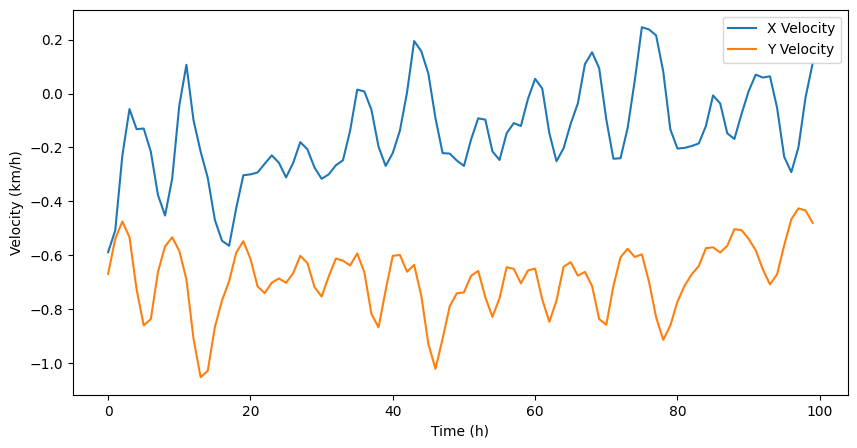

In [16]:
# ==================== PLOT ==================== #

# Plot the X and Y velocity components
plt.figure(figsize=(10, 5))
plt.plot(Vxl, label='X Velocity')
plt.plot(Vyl, label='Y Velocity')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Velocity (km/h)')
plt.show()
